In [2]:
import numpy as np 
import pickle
import os
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
datasets = ['FEMNIST', 'CIFAR']

In [4]:



def read_pickle(filepath):
    # Open the pickle file in read-binary mode
    with open(filepath, 'rb') as f:
        # Load the object from the file using pickle.load()
        data = pickle.load(f)
    return data



class Exp : 

    def __init__(self, root) : 
        self.root = root 
        self.basename = os.path.basename(root)
        self.balanced = 'balanced' in self.basename 
        self.aug = 'aug' in self.basename
        self.compress = 'compress' in self.basename
        self.select = 'select' in self.basename
        self.N_alignment = int(self.basename.split('_')[-1].split('exp')[-1])
        self.label = 'iid' if self.balanced else 'noniid'
        self.label += '_aug' if self.aug else ''
        self.label += '_compress' if self.compress else ''
        self.label += '_select' if self.select else ''

        if self.aug and not self.select and not self.compress :
            self.label = 'FedAKD'
        elif self.aug and self.select and not self.compress: 
            self.label = 'FedSAKD'
        elif self.aug and not self.select and self.compress :
            self.label = 'CFedAKD'
        elif self.aug and self.select and self.compress :
            self.label = 'CFedSAKD'

        elif not self.aug and not self.select and not self.compress :
            self.label = 'FedMD' 
        elif not self.aug and self.select and not self.compress : 
            self.label = 'FedSMD' 
        elif not self.aug and not self.select and self.compress : 
            self.label = 'CFedMD' 
        elif not self.aug and self.select and self.compress :
            self.label = 'CFedSMD'
        
        self.corrupt = False
        self.read_data() 
        self.read_log()
    
    def read_data(self) : 
        models_dir = os.path.join(self.root, 'models')
        try : 
            self.data_dict = read_pickle(os.path.join(self.root, 'col_performance.pkl'))
            self.corrupt = False
        except Exception as e: 
            print(e)
            self.corrupt = True
            return 

        self.N_clients = len(self.data_dict)
        self.N_rounds = len(self.data_dict[0])
        self.data = np.zeros((self.N_clients, self.N_rounds))
        
        for i in range(self.N_clients) :
            self.data[i] = self.data_dict[i]
        
        self.avg_data = np.mean(self.data, axis=0)
        self.std_data = np.std(self.data, axis=0)

    
    def read_log(self) :
        if self.corrupt :
            return
            
        log_file = os.path.join(self.root, 'file.log')
        
        try : 
            with open(log_file, 'r') as f : 
                self.log = f.readlines()
        except Exception as e:
            print(e)
            self.corrupt = True
            return
        
        self.ratios = np.zeros((self.N_clients, self.N_rounds)) 
        self.timestamps = []
        report_ratios = False
        num_client = 0
        num_round = 0
        for line in self.log : 
            if 'round' in line : 
                round_time = line.split('INFO')[0].strip()
                self.timestamps.append( datetime.strptime(round_time, "%Y-%m-%d %H:%M:%S,%f:"))
            elif 'ratio of data saved by selection' in line : 
                report_ratios = True
            elif report_ratios : 
                ratio = line.split(':')[-1].strip()
                if num_client == self.N_clients :
                    report_ratios = False 
                    num_client = 0
                    num_round += 1
                else : 
                    self.ratios[num_client, num_round] = float(ratio)
                    num_client += 1
            
        self.times = [(self.timestamps[i] - self.timestamps[i-1]).total_seconds() for i in range(1, len(self.timestamps))]




        

def valid_exp_dir(dataset_dir) : 
    for d in datasets : 
        if d in dataset_dir : 
            return True
    return False

def dirty_fix_times(times) : 
    def median(lst):
        sorted_lst = sorted(lst)
        n = len(sorted_lst)
        
        if n % 2 == 1:  # Odd number of elements
            return sorted_lst[n // 2]
        else:  # Even number of elements
            left_mid = sorted_lst[(n - 1) // 2]
            right_mid = sorted_lst[n // 2]
            return (left_mid + right_mid) / 2
    med = median(times)
    mean = np.mean(times)
    for i in range(len(times)) :
        if times[i] > 5 * mean : 
            times[i] = med
    return times 



Found 5 valid experiments


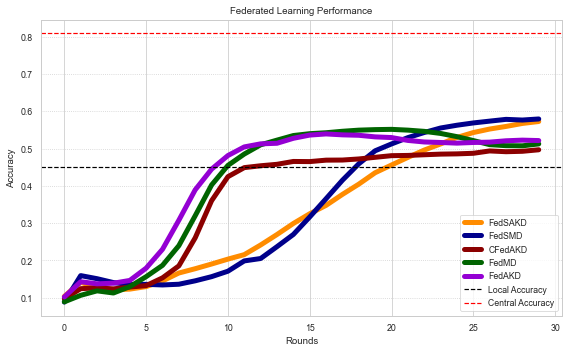

In [11]:

exps = [Exp(join('../fl_results', d)) for d in os.listdir('../fl_results') if valid_exp_dir(d)] 
exps = [d for d in exps if not d.corrupt]

# remove one fedmd exp as there are two versions
fedmd_idx = [i for i, d in enumerate(exps) if d.label == 'FedMD'][0] 
exps.pop(fedmd_idx)


print("Found {} valid experiments".format(len(exps)))


fig, ax = plt.subplots(figsize=(8, 5))
awsome_colors = ['navajowhite', 'lightsteelblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightskyblue', 'lightgrey', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan']
awsome_contrast_colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise']
for i, exp in enumerate(exps):
    ax.plot(exp.avg_data, color = awsome_contrast_colors[i], label = str(exp.label), linewidth=5) 
    
    # ax.fill_between(range(len(exp.avg_data)), exp.avg_data - exp.std_data, exp.avg_data + exp.std_data, color = awsome_contrast_colors[i], alpha=0.1)

# a horizontal dashed line at 0.45 for the local accuracy with a wonderful color
ax.axhline(y=0.45, color='black', linestyle='--', label='Local Accuracy')

# a horizontal dashed line at 0.81 for the central accuracy with another wonderful color (not black) 
ax.axhline(y=0.81, color='red', linestyle='--', label='Central Accuracy')

# Set x and y axis labels and title
ax.set_xlabel('Rounds')
ax.set_ylabel('Accuracy')
ax.set_title('Federated Learning Performance')
ax.legend(loc='lower right')

# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
plt.tight_layout()
plt.savefig("performance.pdf")


Found 6 valid experiments


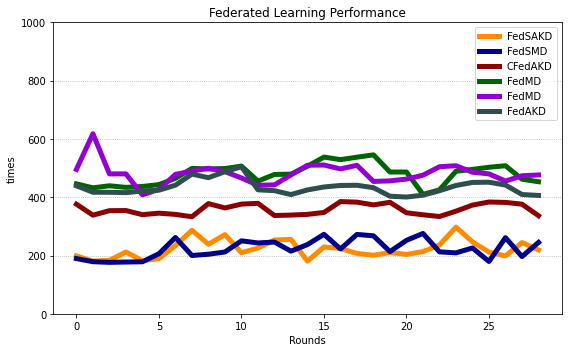

In [6]:

exps = [Exp(join('../fl_results', d)) for d in os.listdir('../fl_results') if valid_exp_dir(d)] 
exps = [d for d in exps if not d.corrupt]

print("Found {} valid experiments".format(len(exps)))


fig, ax = plt.subplots(figsize=(8, 5))
awsome_colors = ['navajowhite', 'lightsteelblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightskyblue', 'lightgrey', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan']
awsome_contrast_colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise']
for i, exp in enumerate(exps):
    ax.plot(np.arange(exp.N_rounds-1), dirty_fix_times(exp.times), color = awsome_contrast_colors[i], label = str(exp.label), linewidth=5) 
    # set y limit 
    ax.set_ylim(0, 1000.0)
    # ax.fill_between(range(len(exp.avg_data)), exp.avg_data - exp.std_data, exp.avg_data + exp.std_data, color = awsome_contrast_colors[i], alpha=0.1)
    
# Set x and y axis labels and title
ax.set_xlabel('Rounds')
ax.set_ylabel('times')
ax.set_title('Federated Learning Performance')
ax.legend(loc='best')


# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
plt.tight_layout()
plt.savefig("times.pdf")


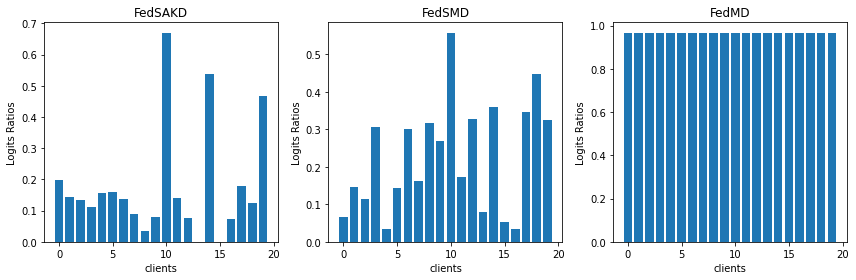

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 4 experiments, adjust as necessary
n_rows = 1
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4))  # Adjust the size accordingly

# Flatten the axs array
axs_flat = np.ravel(axs)

select_exps = [exps[0], exps[1], exps[3]]
for i, exp in enumerate(select_exps):
    ax = axs_flat[i]
    
    ax.bar(np.arange(exp.N_clients), np.mean(exp.ratios, axis = 1))
    # Uncomment below if needed
    # ax.fill_between(range(len(exp.avg_data)), exp.avg_data - exp.std_data, exp.avg_data + exp.std_data, color=awsome_contrast_colors[i], alpha=0.1)
    
    # Set x and y axis labels and title
    ax.set_xlabel('clients')
    ax.set_ylabel('Logits Ratios')
    ax.set_title(str(exp.label))
    # ax.legend(loc='lower right')
    # ax.grid(axis='y', linestyle='dotted')

plt.tight_layout()
# save as a pdf figure 
plt.savefig("logits_ratios_per_client.pdf")
plt.show()


FedSAKD


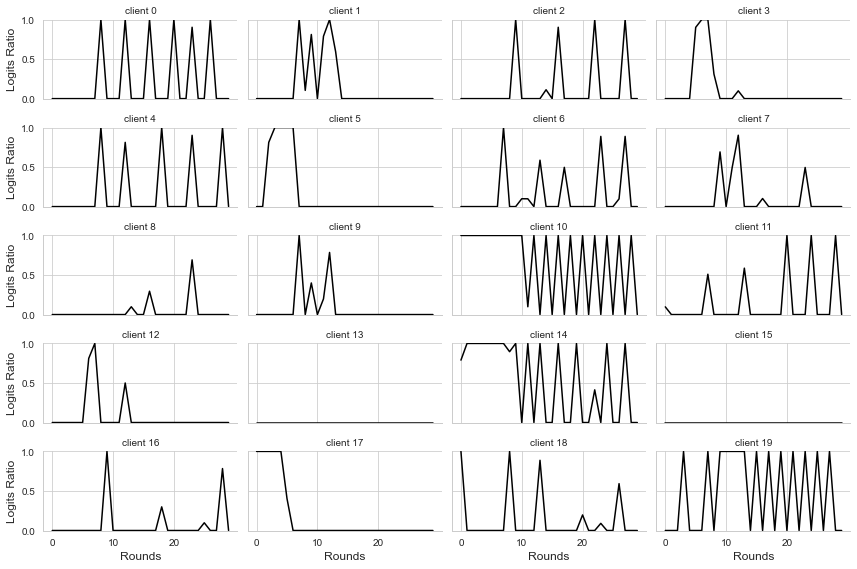

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("paper")

select_exp = [exp for exp in exps if exp.label == 'FedSAKD'][0]
print(select_exp.label)

# Assuming you have 4 experiments, adjust as necessary
n_rows = 5
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8), sharex=True, sharey=True)

# Flatten the axs array
axs_flat = np.ravel(axs)

# Pick a Seaborn color palette
palette = sns.color_palette("husl", select_exp.N_clients)

for c in range(select_exp.N_clients):
    ax = axs_flat[c]
    sns.lineplot(x=np.arange(select_exp.N_rounds), y=select_exp.ratios[c, :], ax=ax, color='black', linewidth=1.5)

    # Setting y-axis range from 0 to 1
    ax.set_ylim(0, 1)
    
    # This would make sure only the subplots on the bottom row and leftmost column have axis labels
    if c // n_cols == n_rows - 1:  # Bottom row
        ax.set_xlabel('Rounds', fontsize=12)
        # Here, as an example, we set x-ticks at intervals of 10. Adjust as necessary.
        ax.set_xticks(np.arange(0, select_exp.N_rounds, 10))
    if c % n_cols == 0:  # Leftmost column
        ax.set_ylabel('Logits Ratio', fontsize=12)

    # Title (adjust font size if necessary)
    ax.set_title('client '+ str(c), fontsize=10)
    
    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Despine for cleaner look
    sns.despine(ax=ax)

# # Adjusting tick visibility
# for ax in axs[:-1, :].flatten():  # All but the bottom row
#     ax.set_xticks([])
#     for label in ax.get_xticklabels():
#         label.set_visible(False)

# for ax in axs[:, 1:].flatten():  # All but the leftmost column
#     ax.set_yticks([])
#     for label in ax.get_yticklabels():
#         label.set_visible(False)

plt.tight_layout()
plt.savefig("logits_ratios_per_client_detailed.pdf")
plt.show()
